### This is a take at making autoencoder form what is in the internet and comparing with our autencoder to determine where we did wrong.

In [2]:
# import necessary library and modules
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [3]:
# Set up GPU for training....
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# Set up data and dataloader
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='./',
                            train=True,
                            transform=transform,
                            download=True)

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=64,
                              shuffle=True)

In [5]:
x = [0]*len(train_data.classes)

for i in range(len(train_data)):
    
    # print(train_data[i][1])
    label = train_data[i][1]
    # print(label)
    x[label] += 1

print(len(train_data))
print(x)
print(sum(x))

60000
[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
60000


In [6]:
numbers = [item.split(' - ')[0] for item in train_data.classes]
letters = [item.split(' - ')[1] for item in train_data.classes]
print(numbers, letters)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']


In [7]:
import pandas as pd

df = pd.DataFrame([letters, x])

df_transposed = df.T

df_transposed.columns = ['labels', 'occurance of labels in the dataset']
df_transposed

,labels,occurance of labels in the dataset
0,zero,5923
1,one,6742
2,two,5958
3,three,6131
4,four,5842
5,five,5421
6,six,5918
7,seven,6265
8,eight,5851
9,nine,5949


In [8]:
# Check the range of the data [which is (0 to 1)]
image, label = train_data[0]

torch.min(image), torch.max(image)

(tensor(0.), tensor(1.))

In [9]:
# Define the Linear AutoEncoder Model class
class AutoEncoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 9)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(9, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [10]:
# Define the CNN AutoEncoder Model class
class AutoEncoder_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 1) # -> N, 64, 1, 1
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # -> N, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [11]:
# Initalize the linear autoencoder  
linear_model = AutoEncoder_Linear().to(device)

# Initalize the cnn autoencoder
cnn_model = AutoEncoder_CNN().to(device)

In [12]:
# Initalize the loss and optimizer for training model

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(linear_model.parameters(),
                             lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)

In [13]:
optimizer.param_groups[0]['lr']

0.001

In [14]:
# Initalize the flatten model to flatten the image because our linear model takes as input only the linear shaped tensor
flatten = nn.Flatten()

In [15]:
# Check the shape of data as it inputs and outputs (flows through) the model
flattened_tensor = flatten(train_data[0][0]).to(device)
print(f'The flattend tensor shape inputted into model: {flattened_tensor.shape}')
output = linear_model(flattened_tensor)
print(f'The encoded shape of the data: {output[0].shape}')
print(f'The decoded shape of the data: {output[1].shape}')

The flattend tensor shape inputted into model: torch.Size([1, 784])
The encoded shape of the data: torch.Size([1, 9])
The decoded shape of the data: torch.Size([1, 784])


In [16]:
# Train our model
num_epochs = 10

for epoch in range(num_epochs):
    linear_model.train()

    print(f'Epcoh:{epoch+1} | Learning Rate: {optimizer.param_groups[0]['lr']}')

    for index, (image, label)in enumerate(train_dataloader):
        image = image.to(device)

        flat_image = flatten(image)
        
        output = linear_model(flat_image)

        loss = criterion(output[1], flat_image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()

    print(f'Loss: {loss}\n--------')

Epcoh:1 | Learning Rate: 0.001
Loss: 0.04006601870059967
--------
Epcoh:2 | Learning Rate: 0.001
Loss: 0.03211479261517525
--------
Epcoh:3 | Learning Rate: 0.001
Loss: 0.031015954911708832
--------
Epcoh:4 | Learning Rate: 0.001
Loss: 0.02626616880297661
--------
Epcoh:5 | Learning Rate: 0.001
Loss: 0.024348575621843338
--------
Epcoh:6 | Learning Rate: 0.001
Loss: 0.02888724021613598
--------
Epcoh:7 | Learning Rate: 0.001
Loss: 0.026634521782398224
--------
Epcoh:8 | Learning Rate: 0.001
Loss: 0.01967691443860531
--------
Epcoh:9 | Learning Rate: 0.001
Loss: 0.021022513508796692
--------
Epcoh:10 | Learning Rate: 0.001
Loss: 0.02599373087286949
--------


Text(0.5, 1.0, 'Encoded Data Output')

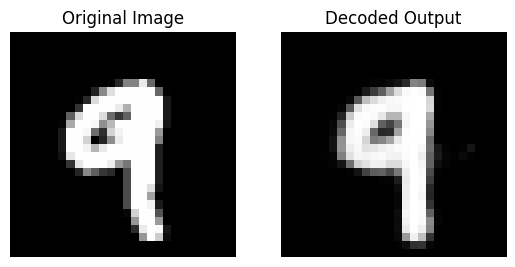

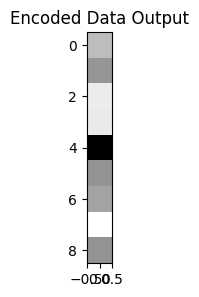

In [17]:
# Visualize the original data/image, encoded output and the decodeded output of the trained model
import random

# picks a random image from our test data and flattens it (making it ready to pass into our linear model)
rand_int = random.choice(range(len(train_data)))
image = train_data[rand_int][0]
flat_image = flatten(image)

# pass the flattend data into the model
model_output = linear_model(flat_image.to(device))

# get the encoded output data and reshape it to plot in graph/image
model_encoded_output = model_output[0]
encoded_output_reshaped = model_encoded_output.reshape(1, -1, 1).detach().cpu()

# get the decode output data and reshape it to plot in graph/image 
model_decoded_output = model_output[1]
decoded_output_reshaped = model_decoded_output.reshape(-1, 28, 28).detach().cpu()

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0), cmap='grey')
plt.title('Original Image')
plt.axis(False)

# plot the decode image
plt.subplot(1, 2, 2)
plt.imshow(decoded_output_reshaped.permute(1, 2, 0), cmap='grey')
plt.title('Decoded Output')
plt.axis(False)

# plot the encoded latent representation
plt.figure(figsize=(3, 3))
plt.imshow(encoded_output_reshaped.permute(1, 2, 0), cmap='grey')
plt.title('Encoded Data Output')

In [18]:
# Get all the predicted labels from the trained model on the train data and store them in 'encoded_data' list  

with torch.inference_mode():

    linear_model.eval()

    encoded_data = []
    label_data = []

    for image, label in train_dataloader:
        image = image.to(device)

        flat_image = flatten(image)
        
        encoded_output = linear_model(flat_image)[0]
        encoded_data.append(encoded_output)
        label_data.append(label)
        
encoded_data = torch.concat(encoded_data)
label_data = torch.concat(label_data)

In [19]:
# Check the shape of the encoded data and their respective true labels
encoded_data.shape, label_data.shape

(torch.Size([60000, 9]), torch.Size([60000]))

# KMEANS Clustering Algorithm starts here

In [20]:
# Apply k-means clustering algorithm on the encoded data to get the get the cluster and cluster labels

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)

cluster_output = kmeans.fit_predict(encoded_data.cpu().numpy())
cluster_output_tensor = torch.tensor(cluster_output)

# Store the cluster centers

cluster_centers = torch.tensor(kmeans.cluster_centers_)
pseudo_labels = torch.tensor(kmeans.labels_)



In [21]:
cluster_output_tensor, pseudo_labels

(tensor([5, 2, 1,  ..., 9, 2, 1], dtype=torch.int32),
 tensor([5, 2, 1,  ..., 9, 2, 1], dtype=torch.int32))

In [22]:
# AMI score to access the quality of the cluster
from sklearn.metrics import adjusted_mutual_info_score

ami_score = adjusted_mutual_info_score(label_data, cluster_output)
print(ami_score)

0.4565415949265316


# Apply the clustering loss (KBL : Kullback-Leibler Divergence)

In [23]:
# This is the clustering layer. It will calculate the softmax probability of each point belonging to each cluster.

class ClusteringLayer(nn.Module):
    def __init__(self, cluster_centers):
        super().__init__()
        self.cluster_centers = cluster_centers

    def forward(self, encoded_data):
        # Compute the distance between the encoded points and cluster centers
        distances = torch.cdist(encoded_data.cpu(), self.cluster_centers)

        

        # Convert the distances to probabilities (soft assignments)
        soft_assignments = torch.nn.functional.softmax(-distances, dim=1)

        return soft_assignments
    

clustering_layer = ClusteringLayer(cluster_centers=cluster_centers)

In [24]:
def clustering_loss(predicted_probs, true_probs):
    """
    Compute KLD loss between predicted cluster probabilities and true cluster probabilities.
    true_probs is one-hot encoded or soft probability for each data point.
    predicted_probs is the output from the softmax (soft cluster assignments).
    """
    epsilon = 1e-8  # to avoid division by zero or log(0)
    # KLD loss formula: D_KL(P || Q) = sum(P * log(P / Q))
    kld = torch.sum(true_probs * torch.log((true_probs + epsilon) / (predicted_probs + epsilon)), dim=1)
    return kld.mean()


In [25]:
reconstruction_loss = nn.MSELoss()

In [26]:
def fine_tune_autoencoder(model, data_loader, clustering_layer, epochs=10, lambda_clustering=1.0):
    model.train()
    for epoch in range(epochs):
        total_loss = 0

        for data, label in data_loader:
            optimizer.zero_grad()

            data = data.view(data.size(0), -1).to(device) # Flatten the image and take it to the GPU

            encoded_data, reconstruction = model(data)

            # Compute reconstruction loss
            r_loss = reconstruction_loss(reconstruction, data)

            # Compute soft assignments from the clustering layer
            soft_assignments = clustering_layer(encoded_data)


fine_tune_autoencoder(linear_model, train_dataloader, clustering_layer, epochs=10, lambda_clustering=1.0)

In [27]:
optimizer_2 = torch.optim.Adam(params=linear_model.parameters(),
                               lr=1)

In [28]:
def fine_tune_autoencoder(model, data_loader, clustering_layer, epochs=10, lambda_clustering=1.0):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, label) in enumerate(data_loader):
            optimizer.zero_grad()
            data = data.view(data.size(0), -1).to(device)  # Flatten images
            encoded_data, reconstruction = model(data)
            
            # Compute reconstruction loss
            reconstruction_loss = nn.MSELoss()(reconstruction, data)
            
            # Compute soft assignments from the clustering layer
            soft_assignments = clustering_layer(encoded_data)

        



            # Get the current batch pseudo-labels
            start_idx = batch_idx * data.size(0)  # Start index for the current batch
            end_idx = start_idx + data.size(0)   # End index for the current batch
            
            # Slice the pseudo_labels corresponding to the current batch
            current_pseudo_labels = pseudo_labels[start_idx:end_idx]  # Get the relevant part of pseudo_labels

            # Create soft one-hot pseudo-labels based on K-means cluster assignments
            true_probs = torch.zeros(data.size(0), cluster_centers.size(0))  # N x K
            for i, label in enumerate(current_pseudo_labels):
                true_probs[i, label] = 1  # One-hot assignment
            
            # Compute clustering loss
            clustering_loss_value = clustering_loss(true_probs, soft_assignments)
            
            # Total loss: Reconstruction loss + Clustering loss
            loss = reconstruction_loss + lambda_clustering * clustering_loss_value
            loss.backward()
            optimizer_2.step()
            
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Total Loss: {total_loss / len(data_loader)}")

# Fine-tune the model with both reconstruction and clustering losses
fine_tune_autoencoder(linear_model, train_dataloader, clustering_layer, epochs=10, lambda_clustering=1.0)


Epoch 1/10, Total Loss: 15.320318131558677
Epoch 2/10, Total Loss: 15.28164476118108
Epoch 3/10, Total Loss: 15.313185822989132
Epoch 4/10, Total Loss: 15.316529541381641
Epoch 5/10, Total Loss: 15.312389767246206
Epoch 6/10, Total Loss: 15.33533542852666
Epoch 7/10, Total Loss: 15.299244759687737
Epoch 8/10, Total Loss: 15.305370203721752
Epoch 9/10, Total Loss: 15.291232762814586
Epoch 10/10, Total Loss: 15.30884063980981


In [29]:
# Get the confusion matrix between the cluster labels and the true labels of the data

from torchmetrics import ConfusionMatrix

confusion_matrix = ConfusionMatrix(task='multiclass', num_classes=10)

confusion_matrix_tensor = confusion_matrix(cluster_output_tensor, label_data)
confusion_matrix_tensor

tensor([[ 387,  348,   56,    1,   40,  450,   25, 3676,  747,  193],
        [  19,   13, 3458,   15,    5,  103, 3109,    0,    3,   17],
        [  17, 3816,  158,   37,    6, 1361,  122,   78,   48,  315],
        [  20,  736,   33,    6,    0, 4220,   10,    5,   11, 1090],
        [1736,   40,  316,  415, 2570,   31,  400,   22,  311,    1],
        [ 133,  219,   98,    5,    0, 2391,  627,   26,   37, 1885],
        [  32,  177, 1061,    0,  122,  251,   50,  144, 4038,   43],
        [2002,  190,  383, 2730,  377,  204,  315,    3,    3,   58],
        [ 101,  172,  103,  150,    9, 1576,  135,   23,    5, 3577],
        [2628,   43,  415, 1132, 1165,  193,  243,   29,   13,   88]])

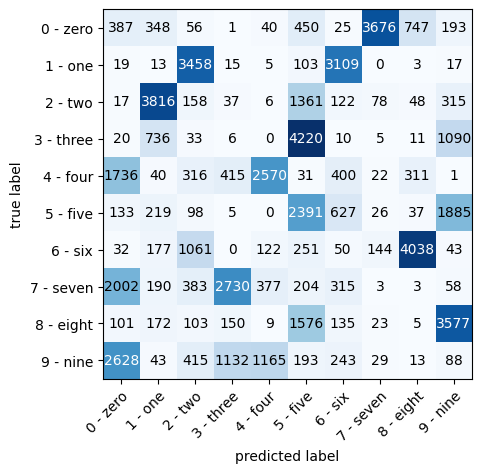

In [30]:
# Plot the kmeans label vs true label confusion matrix

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(
    conf_mat=confusion_matrix_tensor.numpy(),
    class_names=train_data.classes)

In [31]:
# Store the number of correctly predicted labels in a list
confusion_matrix_tensor[0][0]

total = []
for i in range(len(train_data.classes)):
    correct = confusion_matrix_tensor[i][i].item()
    total.append(correct)

total

[387, 13, 158, 6, 2570, 2391, 50, 3, 5, 88]

In [32]:
# Calculate the accuracy of the prediction
total_sum = sum(total)
total_sum

acc = (total_sum / len(label_data)) * 100

print(f'Model Accuracy: {acc:.2f} %')

Model Accuracy: 9.45 %


In [33]:
from Modules.conf_mat_acc import conf_mat_acc

acc = conf_mat_acc(confusion_matrix_tensor=confusion_matrix_tensor,
                   num_labels=len(train_data.classes),
                   len_data=len(train_data))
acc

ModuleNotFoundError: No module named 'Modules'

In [ ]:
# Chcek the maximum and minimum value in the 'encoded_data'
encoded_data.max(), encoded_data.min()

(tensor(26.8186, device='cuda:0'), tensor(-28.6839, device='cuda:0'))

In [ ]:
encoded_data = encoded_data.cpu()

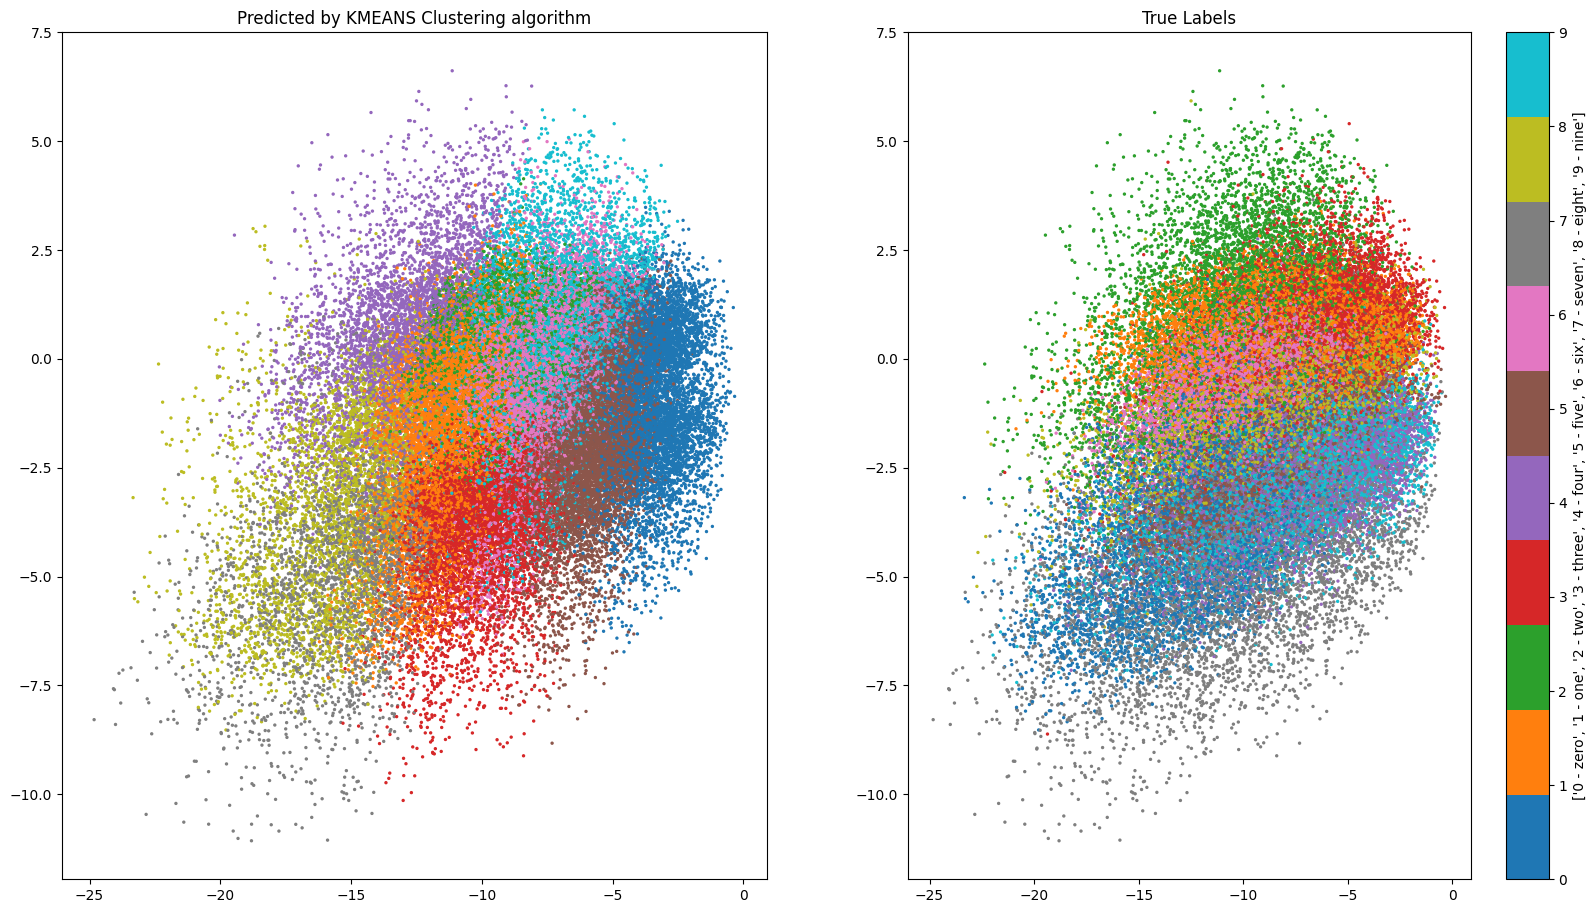

In [ ]:
# Since our encoded data is a 2 dimensional vector we can plot it in 2d graph to visualize the data



# Following sample code for plotting in 3d graph
# # Follwing graph gives the predicted labels for the cluster by our clustering algorithm
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# scatter = ax.scatter(encoded_data[:, 0], encoded_data[:, 1], encoded_data[:, 2], c = kmeans.labels_)



fig, ax = plt.subplots(1, 2, figsize=(20, 11))

scatter0 = ax[0].scatter(encoded_data[:, 0], encoded_data[:, 1], c=cluster_output, cmap='tab10', s=2)
ax[0].set_title('Predicted by KMEANS Clustering algorithm')

scatter1 = ax[1].scatter(encoded_data[:, 0], encoded_data[:, 1], c=label_data, cmap='tab10', s=2)
ax[1].set_title('True Labels')

cbar = plt.colorbar(scatter1)
cbar.set_label(train_data.classes)




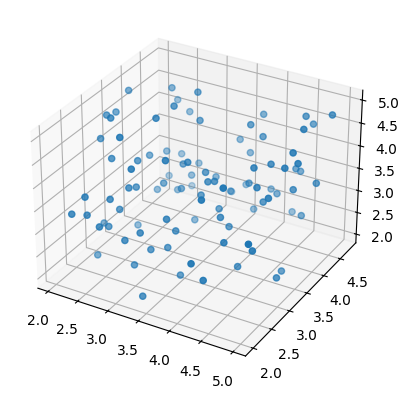

In [ ]:
# What the true labels for the cluster should be.....
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})



import torch

a = 2   # lower bound
b = 5   # upper bound
size = (100, 3)  # shape of the tensor

enc = a + (b - a) * torch.rand(size)
'NOTE: torch.rand only generates number between 0 to 1. [0, 1)'

ax.scatter(enc[:, 0], enc[:, 1], enc[:, 2])


# DBSCAN Clustering Algorithm starts here

In [ ]:
# Apply DBSCAN clustering algorith to the encoded data ot get the cluster and the cluster labels

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.999, min_samples=5)
db_cluster_output = dbscan.fit_predict(encoded_data.cpu().numpy())
db_cluster_output_tensor = torch.tensor(db_cluster_output)

db_cluster_output_tensor.min(), db_cluster_output_tensor.max()

(tensor(-1), tensor(187))

In [ ]:
db_confusion_matrix_tensor = confusion_matrix(db_cluster_output_tensor, label_data)
db_confusion_matrix_tensor

RuntimeError: Detected more unique values in `preds` than expected. Expected only 10 but found 189 in `target`.

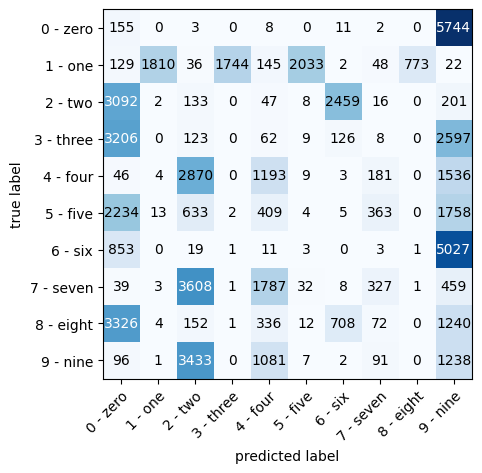

In [ ]:
# Plot the dbcan label vs true label confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=db_confusion_matrix_tensor.numpy(),
    class_names=train_data.classes
)

In [ ]:
# Store the number of correctly predicted labels in a list
db_confusion_matrix_tensor[0][0]

db_total = []
for i in range(len(train_data.classes)):
    correct = db_confusion_matrix_tensor[i][i].item()
    total.append(correct)

db_total

NameError: name 'db_confusion_matrix_tensor' is not defined

In [ ]:
# Calculate the accuracy of the prediction
total_sum = sum(db_total)
total_sum

acc = (total_sum / len(label_data)) * 100

print(f'Model Accuracy: {acc:.2f} %')

Model Accuracy: 8.10 %


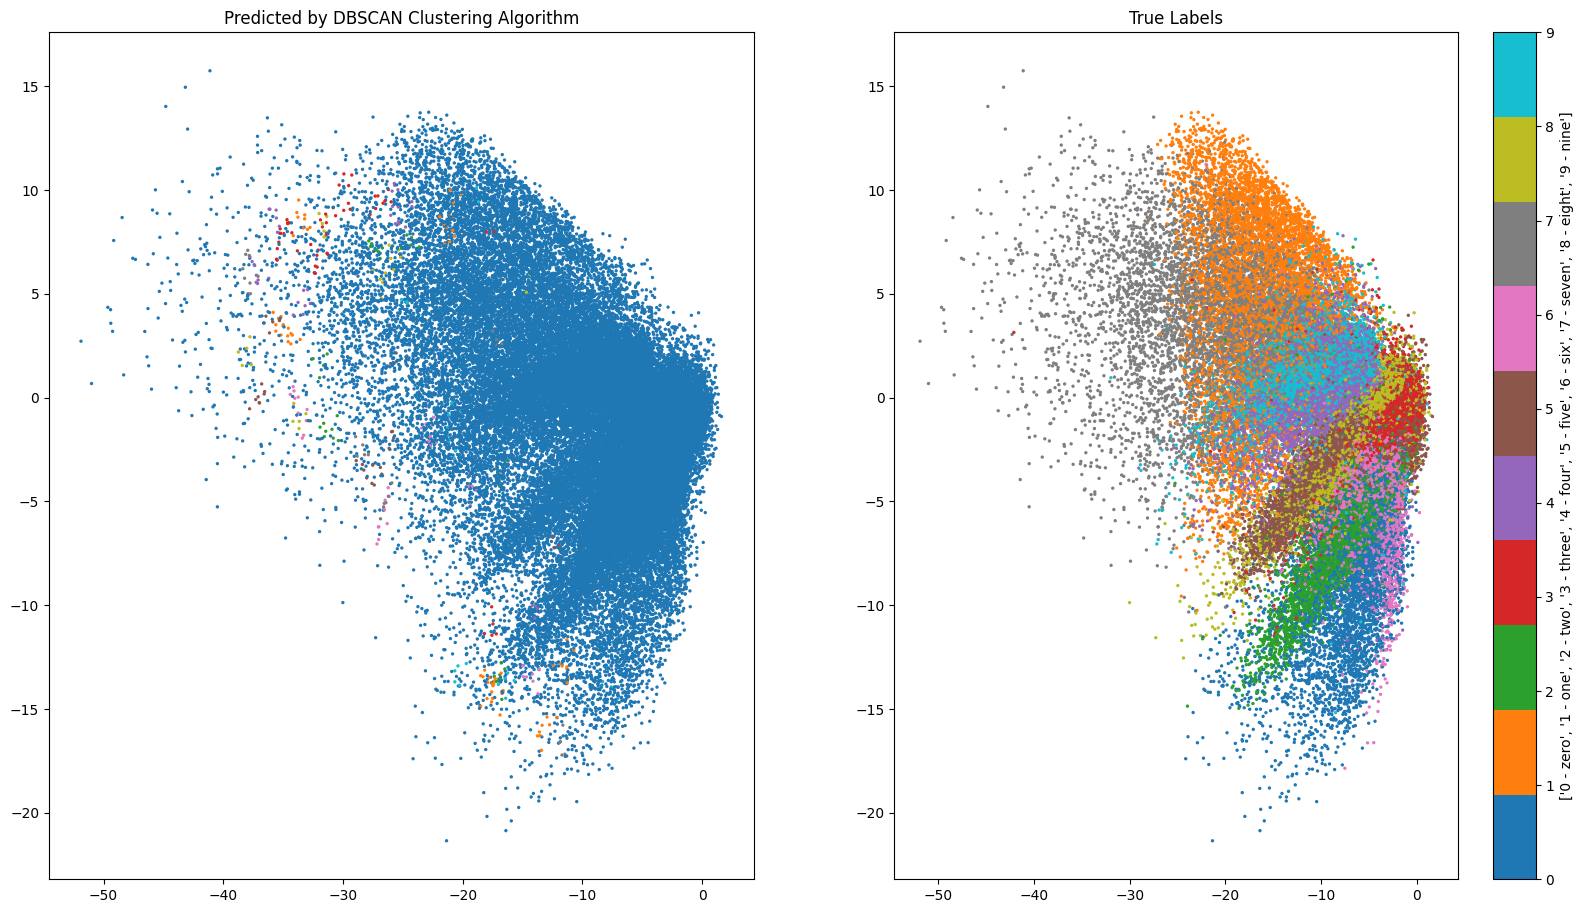

In [ ]:
# Plot the graph between the Predicted labels by the DBSCAN and the true labels


# fig, ax = plt.subplots(1, 2, figsize=(12, 12))

# scatter0 = ax[0].scatter(encoded_data[:, 0], encoded_data[:, 1], c=cluster_output, cmap='tab10')
# ax[0].set_title('Predicted by Clustering algorithm')


fig, ax = plt.subplots(1, 2, figsize=(20, 11))

db_scatter0 = ax[0].scatter(encoded_data[:, 0], encoded_data[:, 1], c=db_cluster_output, cmap='tab10', s=2)
ax[0].set_title('Predicted by DBSCAN Clustering Algorithm')

db_scatter1 = ax[1].scatter(encoded_data[:, 0], encoded_data[:, 1], c=label_data, cmap='tab10', s=2)
ax[1].set_title('True Labels')

cbar = plt.colorbar(db_scatter1)
cbar.set_label(train_data.classes)

# HDBSCAN Clustering Algorithm